# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.




In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

In [ ]:
global device
device = torch.device("cuda:0")

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-4-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
# Age statistics
age_max = df["age"].max()
age_min = df["age"].min()
age_mean = df["age"].mean()

print("The max age is:", age_max, "| The min age is:", age_min, "| The mean age is:", age_mean)
# Yredu statistics
yredu_max = df["yredu"].max()
yredu_min = df["yredu"].min()
yredu_mean = df["yredu"].mean()
print("The max yredu is:", yredu_max, "| The min yredu is:", yredu_min, "| The mean yredu is:", yredu_mean)

# Capgain statistics
capgain_max = df["capgain"].max()
capgain_min = df["capgain"].min()
capgain_mean = df["capgain"].mean()
print("The max capgain is:", capgain_max, "| The min capgain is:", capgain_min, "| The mean capgain is:", capgain_mean)

# Caploss statistics
caploss_max = df["caploss"].max()
caploss_min = df["caploss"].min()
caploss_mean = df["caploss"].mean()
print("The max caploss is:", caploss_max, "| The min caploss is:", caploss_min, "| The mean caploss is:", caploss_mean)

#Workhr statistics
workhr_max = df["workhr"].max()
workhr_min = df["workhr"].min()
workhr_mean = df["workhr"].mean()
print("The max workhr is:", workhr_max, "| The min workhr is:", workhr_min, "| The mean workhr is:", workhr_mean)

The max age is: 90 | The min age is: 17 | The mean age is: 38.58164675532078
The max yredu is: 16 | The min yredu is: 1 | The mean yredu is: 10.0806793403151
The max capgain is: 99999 | The min capgain is: 0 | The mean capgain is: 1077.6488437087312
The max caploss is: 4356 | The min caploss is: 0 | The mean caploss is: 87.303829734959
The max workhr is: 99 | The min workhr is: 1 | The mean workhr is: 40.437455852092995


In [ ]:
# Normalized values
df["age"] = (df["age"]-df["age"].min())/(df["age"].max()-df["age"].min())

df["yredu"] = (df["yredu"]-df["yredu"].min())/(df["yredu"].max()-df["yredu"].min())

df["capgain"] = (df["capgain"]-df["capgain"].min())/(df["capgain"].max()-df["capgain"].min())

df["caploss"] = (df["caploss"]-df["caploss"].min())/(df["caploss"].max()-df["caploss"].min())

df["workhr"] = (df["workhr"]-df["workhr"].min())/(df["workhr"].max()-df["workhr"].min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
total = sum(df["sex"] == " Male") + sum(df["sex"] == " Female")
female = sum(df["sex"] == " Female")
percentage = female/total
print("The percentage of people that are female in the dataset is:", percentage)

The percentage of people that are female in the dataset is: 0.33079450876815825


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print(len(df))
print(len(df_with_missing))
print("Therefore,", len(df_with_missing), "contained missing records and around", len(df_with_missing)/len(df), "percent of records were removed")

32561
1843
Therefore, 1843 contained missing records and around 0.056601455729246644 percent of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
features = set(df_not_missing)
print(features)

{'relationship', 'work', 'capgain', 'yredu', 'sex', 'age', 'edu', 'caploss', 'marriage', 'occupation', 'workhr'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(len(data.columns))
# The data contains 57 columns, which represents the number of features/attributes such as age, workhrs, etc.

57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

print(cat_index)
print(cat_values)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    max_index = np.argmax(onehot)
    categorical_value = cat_values[feature][max_index]
    return categorical_value

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
num_datavals = len(data)
values = np.arange(num_datavals)
np.random.shuffle(values)
group1 = int(len(values)*0.7)
print(group1)
group2 = int(len(values)*0.85)
print(group2)
training_index = values[0:group1]
val_index = values[group1:group2]
test_index = values[group2:]
print(training_index)
print(val_index)
print(test_index)
training_data = datanp[training_index]
val_data = datanp[val_index]
test_data = datanp[test_index]

print(len(training_data))
print(len(val_data))
print(len(test_data))

21502
26110
[ 9944  9160 18905 ...  6996 19418  4818]
[26240  9254 15365 ... 24579 18154 21870]
[29000  6712 26739 ... 10123  5600 14000]
21502
4608
4608


In [ ]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)

In [ ]:
for data, label in enumerate(train_loader):
  print(type(label[0][0][0]))

IndexError: ignored

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch.nn.modules.activation import ReLU
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "AutoEncoder"
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 57),s
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
# The sigmoid activation makes it so that all the outputs are values between 0 and 1.
# This is necessary since we normalized all the data values to be between 0 and 1, so we
# would need the outputs of the decoder to match the values of the data in order to
# verify its accuracy.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

# Create some helper functions
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def val_stats_calc(net, loader, criterion):
  net.eval()
  with torch.no_grad():
    total_loss = 0.0
    total_error = 0.0
    for inputs, labels in iter(loader):
      if torch.cuda.is_available():
        inputs = inputs.to(device)
        labels = labels.cuda(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      total_error += (outputs.argmax(dim=1) != labels).sum().item()

  return (float(total_loss)/len(loader.dataset)), (1-total_error/len(loader.dataset))

# Main training function
def train(model, train_data, valid_data, num_epochs=5, learning_rate=1e-4, batch_size=64): # Use nn.MSELoss()
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    training_acc = []
    training_loss = []
    val_acc = []
    val_loss = []
    for epoch in range(num_epochs):
        n = 0
        train_loss = float(0)
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            n += 1
        valid_loss = float(0)
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            valid_loss += loss.item()

        training_acc.append(get_accuracy(model, train_loader))
        training_loss.append(float(train_loss/(n+1)))
        val_acc.append(get_accuracy(model, valid_loader))
        val_loss.append(float(valid_loss/(n+1)))

        print(("Epoch {}: Train Accuracy: {} Train Loss: {} |"+"Validation Accuracy: {} Validation Loss: {}").format(epoch + 1,training_acc[-1],training_loss[-1],val_acc[-1],val_loss[-1]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    plt.title("Training Accuracy Curve")
    plt.plot(epochs, training_acc)
    plt.xlabel("Num Epochs")
    plt.ylabel("Training Accuracy")
    plt.show()

    plt.title("Training Loss Curve")
    plt.plot(epochs, training_loss)
    plt.xlabel("Num Epochs")
    plt.ylabel("Training loss")
    plt.show()

    plt.title("Validation Accuracy Curve")
    plt.plot(epochs, val_acc)
    plt.xlabel("Num Epochs")
    plt.ylabel("Training Accuracy")
    plt.show()

    plt.title("Validation Loss Curve")
    plt.plot(epochs, val_loss)
    plt.xlabel("Num Epochs")
    plt.ylabel("Training Accuracy")
    plt.show()

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train Accuracy: 0.5581573807087713 Train Loss: 0.08668280643083011 |Validation Accuracy: 0.5601851851851852 Validation Loss: 0.011763766125663783
Epoch 2: Train Accuracy: 0.5761324527950888 Train Loss: 0.05288178635896758 |Validation Accuracy: 0.5784505208333334 Validation Loss: 0.010725640098150559
Epoch 3: Train Accuracy: 0.5876197563017393 Train Loss: 0.04741527612859391 |Validation Accuracy: 0.5856481481481481 Validation Loss: 0.009668061689627295
Epoch 4: Train Accuracy: 0.5916813939788547 Train Loss: 0.04378218622809002 |Validation Accuracy: 0.5928457754629629 Validation Loss: 0.009022746738849034
Epoch 5: Train Accuracy: 0.5956500170526773 Train Loss: 0.04135064042296487 |Validation Accuracy: 0.5971860532407407 Validation Loss: 0.00865112611799768
Epoch 6: Train Accuracy: 0.5954949927138561 Train Loss: 0.03956195598891639 |Validation Accuracy: 0.5958116319444444 Validation Loss: 0.008361552765850327
Epoch 7: Train Accuracy: 0.5995178743062661 Train Loss: 0.0380608302445

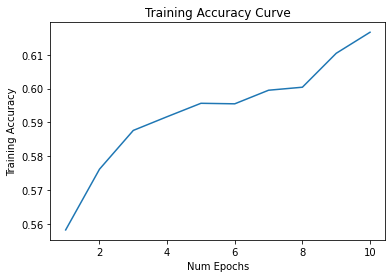

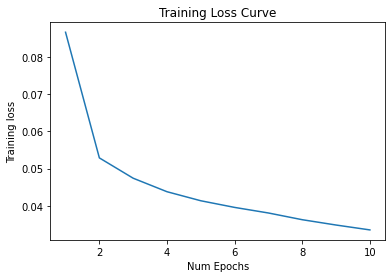

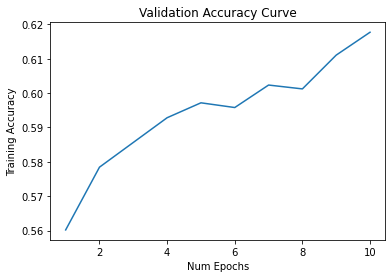

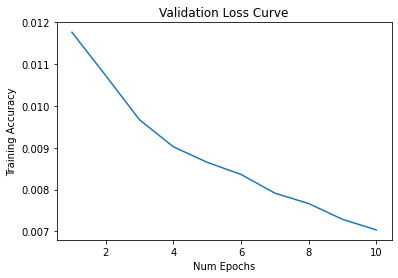

In [ ]:
net = AutoEncoder()
train(net, training_data, val_data, num_epochs=10, batch_size=32, learning_rate=0.0005)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

Epoch 1: Train Accuracy: 0.45768610671875487 Train Loss: 0.0923697601942924 |Validation Accuracy: 0.45703125 Validation Loss: 0.014577617522821738
Epoch 2: Train Accuracy: 0.5633274424084581 Train Loss: 0.058117264436134436 |Validation Accuracy: 0.5643084490740741 Validation Loss: 0.010976556854607623
Epoch 3: Train Accuracy: 0.5979443772672309 Train Loss: 0.04777203356905288 |Validation Accuracy: 0.5970413773148148 Validation Loss: 0.009605033547350414
Epoch 4: Train Accuracy: 0.6019905125104641 Train Loss: 0.04300884017928394 |Validation Accuracy: 0.6008752893518519 Validation Loss: 0.009028341599019109
Epoch 5: Train Accuracy: 0.5980218894366416 Train Loss: 0.04122235309637053 |Validation Accuracy: 0.5964626736111112 Validation Loss: 0.008713016773603114
Epoch 6: Train Accuracy: 0.5968359532446594 Train Loss: 0.04019789375021589 |Validation Accuracy: 0.5971137152777778 Validation Loss: 0.008493318096533926
Epoch 7: Train Accuracy: 0.6022928099711655 Train Loss: 0.03938302748669133 |

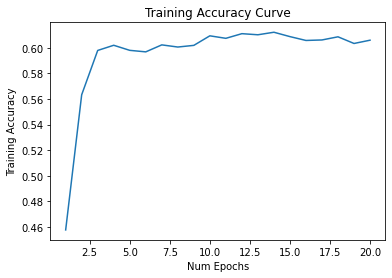

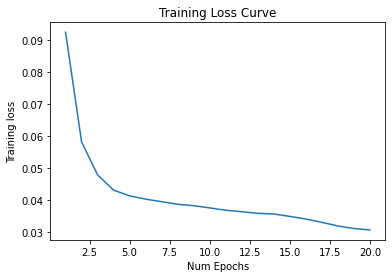

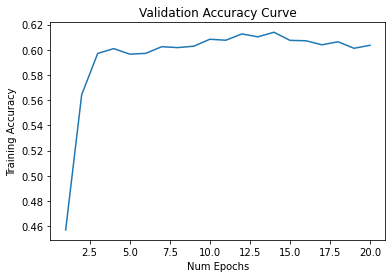

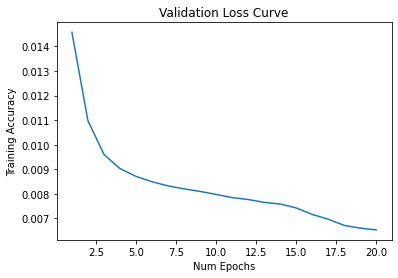

In [ ]:
# Model 1
model_1 = AutoEncoder()
# The initial set of hyperparameters did produce a steady increase in both training and validation accuracy,
# so I wanted to increase the number of epochs to 20 to see how accurate the model could get, and also to see if
# any overfitting would occur at later epochs.
train(model_1, training_data, val_data, num_epochs=20, batch_size=32, learning_rate=0.0005)

Epoch 1: Train Accuracy: 0.4576551018509906 Train Loss: 0.11463031639242738 |Validation Accuracy: 0.45699508101851855 Validation Loss: 0.015026241496691718
Epoch 2: Train Accuracy: 0.4904582519455555 Train Loss: 0.06869069526651847 |Validation Accuracy: 0.4881727430555556 Validation Loss: 0.014009544719839662
Epoch 3: Train Accuracy: 0.5712491861222212 Train Loss: 0.05678379930312626 |Validation Accuracy: 0.5707103587962963 Validation Loss: 0.01140491668831347
Epoch 4: Train Accuracy: 0.5791709298359843 Train Loss: 0.051382676474418416 |Validation Accuracy: 0.5773654513888888 Validation Loss: 0.010466878067492023
Epoch 5: Train Accuracy: 0.5922317303816699 Train Loss: 0.047437524881755566 |Validation Accuracy: 0.5934606481481481 Validation Loss: 0.009771560713958316
Epoch 6: Train Accuracy: 0.5936502030818839 Train Loss: 0.04448531772554452 |Validation Accuracy: 0.5940755208333334 Validation Loss: 0.009344767336940906
Epoch 7: Train Accuracy: 0.6005100300747217 Train Loss: 0.0423986370

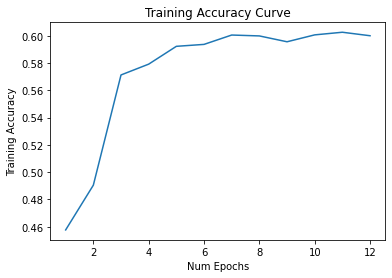

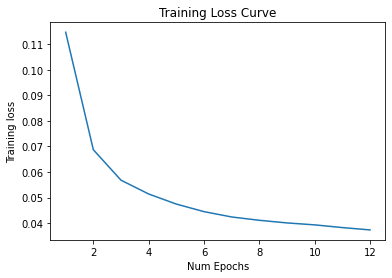

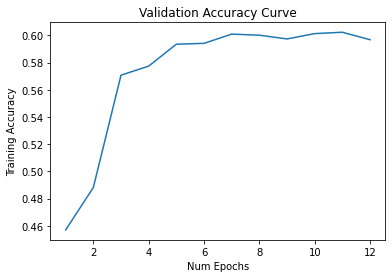

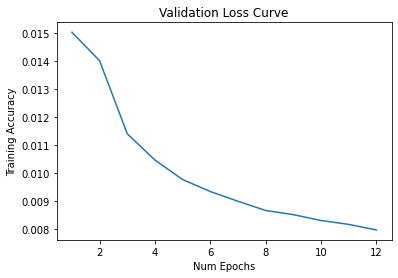

In [ ]:
# Model 2
model_2 = AutoEncoder()
# I learned that the training and validation accuracy hit a plateau after 12 epochs, so I kept this number the same
# but increased the batch_size in the hopes of increasing the learning rate and getting higher accuracies.
train(model_2, training_data, val_data, num_epochs=12, batch_size=64, learning_rate=0.0005)

Epoch 1: Train Accuracy: 0.558250395312064 Train Loss: 0.08007711014346418 |Validation Accuracy: 0.5598596643518519 Validation Loss: 0.011790574427256789
Epoch 2: Train Accuracy: 0.5915031159892103 Train Loss: 0.04938344751522056 |Validation Accuracy: 0.5898799189814815 Validation Loss: 0.00956817734073211
Epoch 3: Train Accuracy: 0.589131243605246 Train Loss: 0.04183416141067005 |Validation Accuracy: 0.5907841435185185 Validation Loss: 0.008644420747682563
Epoch 4: Train Accuracy: 0.6083697640529563 Train Loss: 0.03900994812408227 |Validation Accuracy: 0.6068070023148148 Validation Loss: 0.008129428955899305
Epoch 5: Train Accuracy: 0.615330356866028 Train Loss: 0.036766589249734714 |Validation Accuracy: 0.61328125 Validation Loss: 0.007683187188998551
Epoch 6: Train Accuracy: 0.6083775152698974 Train Loss: 0.03543608451060076 |Validation Accuracy: 0.6089409722222222 Validation Loss: 0.007437597550617816
Epoch 7: Train Accuracy: 0.6049204725141847 Train Loss: 0.034461546002888574 |Val

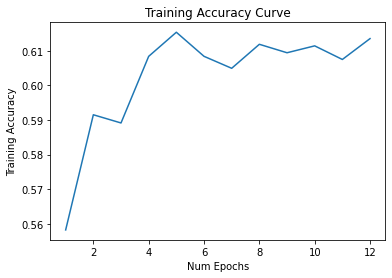

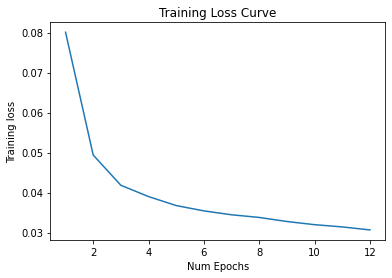

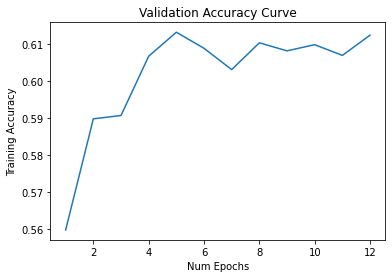

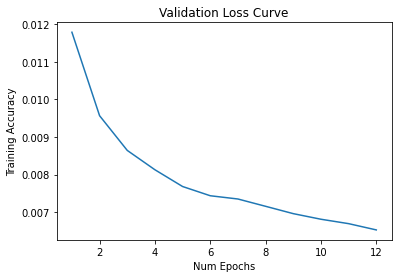

In [ ]:
# Model 3
model_3 = AutoEncoder()
# Increasing the batch size actually resulted in a lower accuracy at the 12th epoch, so
# I decided to keep the batch_size the same at 32 and instead increased the learning rate in the
# hopes of getting a higher accuracy at the 12th epoch.
train(model_3, training_data, val_data, num_epochs=12, batch_size=32, learning_rate=0.001)

Epoch 1: Train Accuracy: 0.5766130282454345 Train Loss: 0.07540357113438056 |Validation Accuracy: 0.5783781828703703 Validation Loss: 0.010366329223050405
Epoch 2: Train Accuracy: 0.5962236071063157 Train Loss: 0.04174366074698641 |Validation Accuracy: 0.5946903935185185 Validation Loss: 0.008007068076291375
Epoch 3: Train Accuracy: 0.5964638948314885 Train Loss: 0.03542643103521611 |Validation Accuracy: 0.5944372106481481 Validation Loss: 0.007390458684796564
Epoch 4: Train Accuracy: 0.6031609462685642 Train Loss: 0.03331086854069849 |Validation Accuracy: 0.6004412615740741 Validation Loss: 0.006997228249973918
Epoch 5: Train Accuracy: 0.605215018757945 Train Loss: 0.031885929754416266 |Validation Accuracy: 0.6031539351851852 Validation Loss: 0.006603528198856656
Epoch 6: Train Accuracy: 0.6107648900877438 Train Loss: 0.029225619111270997 |Validation Accuracy: 0.6078559027777778 Validation Loss: 0.006102308705670518
Epoch 7: Train Accuracy: 0.6041608532539609 Train Loss: 0.02740016710

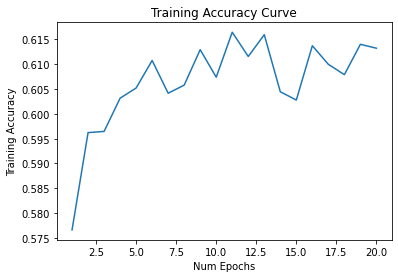

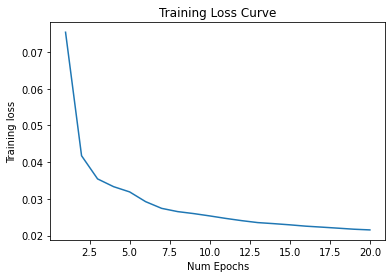

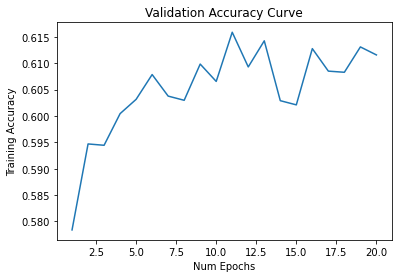

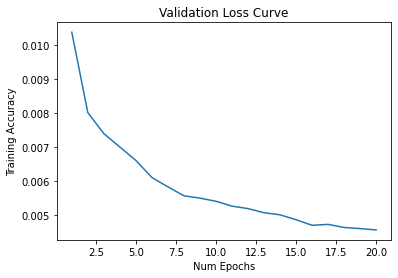

In [ ]:
# Model 4
model_4 = AutoEncoder()
# As a follow-up, I decided to use the same hyperparameters as Model 3 but with an increased number of epochs
# to see how high the accuracy would go.
train(model_4, training_data, val_data, num_epochs=20, batch_size=32, learning_rate=0.001)

Epoch 1: Train Accuracy: 0.5336247790903171 Train Loss: 0.09417537534581802 |Validation Accuracy: 0.5368923611111112 Validation Loss: 0.012470725581094137
Epoch 2: Train Accuracy: 0.5771788670821318 Train Loss: 0.0534968262300647 |Validation Accuracy: 0.5760633680555556 Validation Loss: 0.010836940126090093
Epoch 3: Train Accuracy: 0.5988047623476885 Train Loss: 0.04831769959641847 |Validation Accuracy: 0.5962456597222222 Validation Loss: 0.009873951047393617
Epoch 4: Train Accuracy: 0.6126871918891266 Train Loss: 0.04293816375272564 |Validation Accuracy: 0.6099898726851852 Validation Loss: 0.008752456791588389
Epoch 5: Train Accuracy: 0.6054630577000589 Train Loss: 0.038976852856686985 |Validation Accuracy: 0.6018880208333334 Validation Loss: 0.008073731892098306
Epoch 6: Train Accuracy: 0.611431494744675 Train Loss: 0.03629967889220672 |Validation Accuracy: 0.6083622685185185 Validation Loss: 0.007616361376528216
Epoch 7: Train Accuracy: 0.6053700430967662 Train Loss: 0.0340098200824

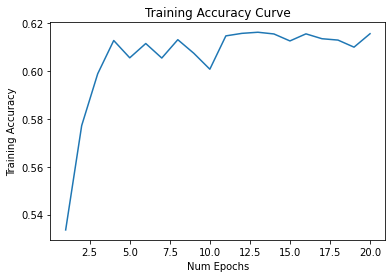

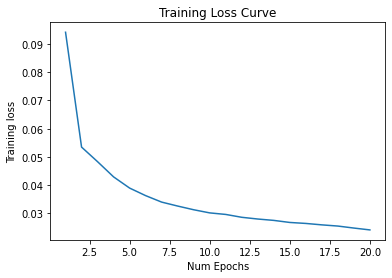

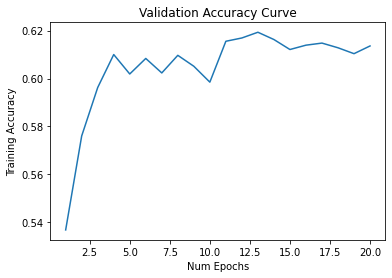

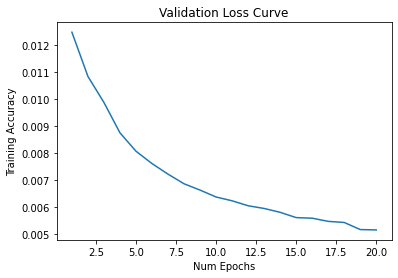

In [ ]:
# Model 5
model_5 = AutoEncoder()
# As a final test, I wanted to see the results of applying all the changes used in each of the previous models
# in one model. So I increased the epoch number to 20, batch_size to 64, and learning rate to 0.001 to see the results.
train(model_5, training_data, val_data, num_epochs=20, batch_size=64, learning_rate=0.001)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
test_accuracy = get_accuracy(model_5, test_dataloader)
print("Final Test Accuracy:", test_accuracy)

Final Test Accuracy: 0.6129918981481481


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
most_common_values = {}

for column in df_not_missing.columns:
  # get the most common value for each column
  most_common_values[column] = df_not_missing[column].value_counts().idxmax()

baseline_accuracy = sum(df_not_missing["marriage"] == most_common_values["marriage"])/len(df_not_missing)
print("The test accuracy of the baseline model is:", baseline_accuracy)

The test accuracy of the baseline model is: 0.4667947131974738


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
# The test accuracy of my model from part a) was 0.6129918981481481 compared to the baseline
# test accuracy of 0.4667947131974738. Therefore, my model is capable of producing better test results.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
first_test_item = test_data[0]
get_features(first_test_item)

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

In [ ]:
# I would say that it would be reasonable for a human to guess the individual's level of education,
# mainly by looking at their occupation. We can see that they are a Prof which would require some
# form of post-secondary education.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
actual_education = zero_out_feature(test_data[:1], "edu")[0]
predicted_education = model_5(torch.from_numpy(actual_education))
get_feature(predicted_education.detach().numpy(), "edu")

'Bachelors'

In [ ]:
# My model predicted that the person's education level is a Bachelors, which is correct.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
most_common_values["edu"]

' HS-grad'

In [ ]:
# The baseline's prediction is highschool graduate, which is incorrect.